In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, BatchNormalization, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25
embedding_dropout = 0.25
n_epochs = 100
epoch = 0


train_lstm_emb128_batchnormalized_before_aucs = np.zeros((folds,n_epochs))
test_lstm_emb128_batchnormalized_before_aucs = np.zeros((folds,n_epochs))


train_lstm_emb128_batchnormalized_after_aucs = np.zeros((folds,n_epochs))
test_lstm_emb128_batchnormalized_after_aucs = np.zeros((folds,n_epochs))

train_lstm_emb128_aucs = np.zeros((folds,n_epochs))
test_lstm_emb128_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    # lstm128 batchnorm_before
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 128, mask_zero = True)(sequence)
    batchnormalized_embedded = TimeDistributed (BatchNormalization(mode=2))(embedded)
    
    forwards = LSTM(hidden )(batchnormalized_embedded)
    backwards = LSTM(hidden, go_backwards=True)(batchnormalized_embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    
    lstm_emb128_batchnormalized_before = Model(input = sequence, output = output)
    
    lstm_emb128_batchnormalized_before.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm128 batchnorm_after
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 128,mask_zero = True)(sequence)
    
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    batch_forwards = BatchNormalization(mode=2)(forwards)
    
    backwards = LSTM(hidden,dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)
    batch_backwards = BatchNormalization(mode=2)(backwards)
    
    merged = merge([batch_forwards, batch_backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_emb128_batchnormalized_after= Model(input = sequence, output = output)
    
    lstm_emb128_batchnormalized_after.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 32 
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 128, mask_zero = True)(sequence)
    
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    
    lstm_emb128 = Model(input = sequence, output = output)
    
    lstm_emb128.compile(optimizer = 'adam', loss='mean_squared_error')
    
    for epoch in range(n_epochs):
        
        
        #lstm_emb128_batchnormalized_before
        lstm_emb128_batchnormalized_before.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm_emb128_batchnormalized_before_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_emb128_batchnormalized_before.predict(X[train_idx]))
        test_lstm_emb128_batchnormalized_before_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_emb128_batchnormalized_before.predict(X[test_idx]))
        
        train_lstm_emb128_batchnormalized_before_aucs[i][epoch]=train_lstm_emb128_batchnormalized_before_auc
        test_lstm_emb128_batchnormalized_before_aucs[i][epoch]=test_lstm_emb128_batchnormalized_before_auc
        
        #lstm_emb128_batchnormalized_after 
        lstm_emb128_batchnormalized_after.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm_emb128_batchnormalized_after_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_emb128_batchnormalized_after.predict(X[train_idx]))
        test_lstm_emb128_batchnormalized_after_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_emb128_batchnormalized_after.predict(X[test_idx]))
        
        train_lstm_emb128_batchnormalized_after_aucs[i][epoch]=train_lstm_emb128_batchnormalized_after_auc
        test_lstm_emb128_batchnormalized_after_aucs[i][epoch]=test_lstm_emb128_batchnormalized_after_auc
        
        #lstm_emb128
        lstm_emb128.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm_emb128_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_emb128.predict(X[train_idx]))
        test_lstm_emb128_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_emb128.predict(X[test_idx]))
        
        train_lstm_emb128_aucs[i][epoch]=train_lstm_emb128_auc
        test_lstm_emb128_aucs[i][epoch]=test_lstm_emb128_auc
        
        print(test_lstm_emb128_batchnormalized_before_auc, test_lstm_emb128_batchnormalized_after_auc, test_lstm_emb128_auc, epoch, i)


train_lstm_emb128_batchnormalized_before_aucs_mean = np.mean(train_lstm_emb128_batchnormalized_before_aucs, axis=0)
test_lstm_emb128_batchnormalized_before_aucs_mean = np.mean(test_lstm_emb128_batchnormalized_before_aucs, axis=0)


train_lstm_emb128_batchnormalized_after_aucs_mean = np.mean(train_lstm_emb128_batchnormalized_after_aucs, axis=0)
test_lstm_emb128_batchnormalized_after_aucs_mean = np.mean(test_lstm_emb128_batchnormalized_after_aucs, axis=0)

train_lstm_emb128_aucs_mean =np.mean(train_lstm_emb128_aucs, axis=0)
test_lstm_emb128_aucs_mean = np.mean(test_lstm_emb128_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0459    
Epoch 1/1
6376/6376 [==============================] - 16s - loss: 0.0882    
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0582    
0.920047191013 0.788141099527 0.883228499028 0 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0358    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0636    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0396    
0.924909592094 0.795831668178 0.9366441511 1 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0328    
Epoch 1/1
6376/6376 [==============================] - 15s - loss: 0.0559    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0311    
0.930031445841 0.806537317126 0.94425950963 2 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0312    
Epoch 1/1
6376/6376 [==============================] - 15s - loss: 0.0505   

KeyboardInterrupt: 

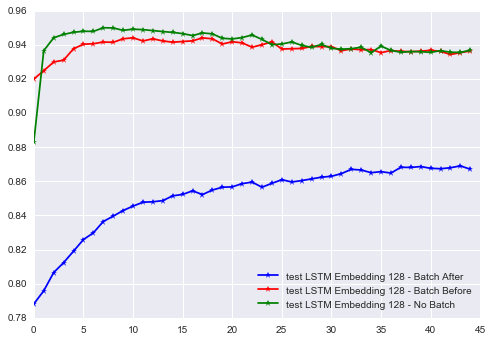

In [4]:
plt.plot( np.arange(0,45,1), test_lstm_emb128_batchnormalized_after_aucs[0,0:45],color='b',marker='*', linestyle='-', label ="test LSTM Embedding 128 - Batch After")
plt.plot( np.arange(0,45,1), test_lstm_emb128_batchnormalized_before_aucs[0,0:45],color='r',marker='*', linestyle='-', label ="test LSTM Embedding 128 - Batch Before")
plt.plot( np.arange(0,45,1), test_lstm_emb128_aucs[0,0:45],color='g',marker='*', linestyle='-', label ="test LSTM Embedding 128 - No Batch")

plt.legend(loc=4)